# Proyecto final 
Alisson García Mejía 

**Objetivos:**
* Análisis del dataset (AED) 
* Identificación del tipo de problema (clasificación o regresión)
* Creación de propuestas de modelos (qué modelo supervisados utilizar, cómo crear la ANN o CNN a utilizar)
* Evaluación de resultados acorde al problema (clasificación: accuracy, precision, recall, f1; regresión: mse, rmse, r^2, etc. )
* Análisis de resultados (determinar el mejor resultado posible y justificar por qué es el mejor resultado posible)
* El resultado debe ser interpretable

Dataset a usar: **Brain tumor** que contiene imgs de glioma, meningioma, no_tumor, pituitary 

## Preprocesamiento y EDA

In [6]:
#preprocesamiento 

import numpy as np
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

#ruta del dataset
dataset_dir = r"/Users/alisson/PycharmProjects/Neurociencias-2025-2/S06_proyecto/dataset"

# resize de las imagenes
img_size = 128 # tamaño de las imagenes

# mapear etiquetas a numeros
label_map = {
    "glioma": "Tumor",
    "meningioma": "Tumor",
    "notumor": "No Tumor",
    "pituitary": "Tumor"
}
# cargar imagenes y etiquetas
def load_images_from_folder(folder_path):
    data = [] 
    for label_folder in os.listdir(folder_path):
        if label_folder not in label_map:
            continue  # skip files/folders not in label_map
        label_name  = label_map[label_folder]
        folder = os.path.join(folder_path, label_folder)
        for filename in tqdm(os.listdir(folder), desc=f"Cargando imágenes de {label_folder}"):
            img_path = os.path.join(folder, filename)
            try: 
                img = cv2.imread(img_path)
                img = cv2.resize(img, (img_size, img_size))
                data.append((img, label_name))
            except:
                pass # si hay un error al cargar la imagen
    return data

# cargamos imagenes de las carpetas Train y Test
train_data = load_images_from_folder(os.path.join(dataset_dir, "Training"))
test_data = load_images_from_folder(os.path.join(dataset_dir, "Testing"))

# combinamos train y test para crear un dataframe
all_data = train_data + test_data


Cargando imágenes de meningioma: 100%|██████████| 306/306 [00:00<00:00, 1152.04it/s]


In [7]:
#aleatorizamos los datos
import random
random.shuffle(all_data)

# separamos caracteristicas y etiquetas
X = []
y = []

for img, label in all_data:
    X.append(img)
    y.append(1 if label == "Tumor" else 0)  # 1 para Tumor, 0 para No Tumor
# convertimos a numpy arrays
X = np.array(X)
y = np.array(y)

# normalizamos las imagenes
X = X / 255.0

# dividimos los datos en train, validation y test sets de 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Imprimimos estructura de los datos
print(f"Total de imágenes: {len(all_data)}")
print(f"Imágenes de entrenamiento:", X_train.shape, y_train.shape)
print(f"Imágenes de validación:", X_val.shape, y_val.shape)
print(f"Imágenes de prueba(test):", X_test.shape, y_test.shape)

Total de imágenes: 7023
Imágenes de entrenamiento: (4916, 128, 128, 3) (4916,)
Imágenes de validación: (1053, 128, 128, 3) (1053,)
Imágenes de prueba(test): (1054, 128, 128, 3) (1054,)


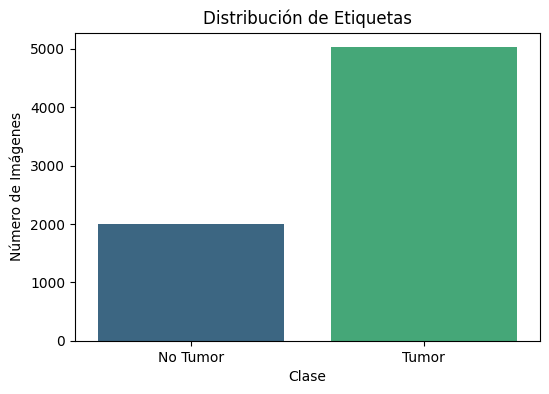

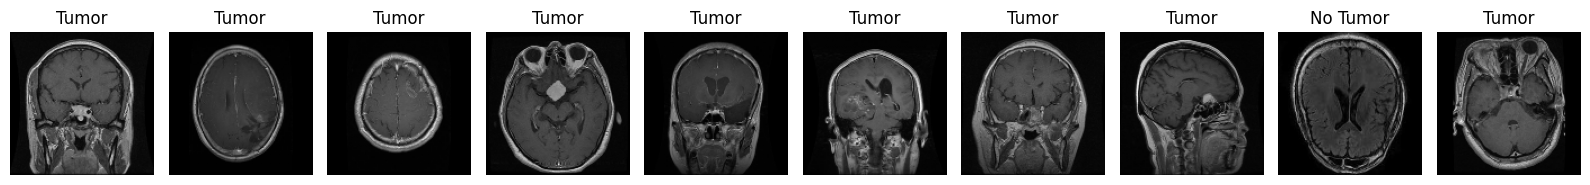

In [8]:
# EDA 

label_names = ["No Tumor", "Tumor"]
class_counts = pd.Series(y).value_counts().sort_index() # contamos las etiquetas

#plotear la distribucion de las etiquetas
plt.figure(figsize=(6, 4))
sns.barplot(x=label_names, y=class_counts, palette="viridis")
plt.title("Distribución de Etiquetas")
plt.xlabel("Clase")
plt.ylabel("Número de Imágenes")
plt.show()

# También podemos visualizar algunas imágenes del dataset :0
def mostrar_imagenes(X, y, label_names, num=10): 
    plt.figure(figsize=(16, 4))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(X[i])
        plt.title(label_names[y[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

mostrar_imagenes(X_train, y_train, label_names)


## Tipo de problema 

Observando las etiquetas (y) y nuestro objetivo de este dataset que es, identificar "tumor" o "no tumor", claramente es un problema de **clasificación**, ya que queremos predecir si en una imagen se encuentra un tumor o no. 

## Propuestas de modelos 
* Qué modelos supervisados podemos usar
* Cómo crear la ANN o CNN a utilizar 

Ya que son imágenes de MRI, podemos extraer las características de las imágenes como: textura, bordes, intensidad, entre otras, por medio de modelos clásicos como Máquinas de Soporte Vectorial (SVM), Random Forest o KNN. 
Pero una mejor opción sería, usar **Redes Neuronales Convolucionales (CNNs)** porque se pueden extraer estas características para detectar patrones complejos y, al entrenar esta red para la detección de objetos, se pueden reconocer características no solo del cerebro sino también la detección y características del tumor, aumentando la fiabilidad del modelo.


In [15]:
# Aplicación de CNN 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Definimos la arquitectura de la CNN
model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)), # entrada de imagenes de 128x128 con 3 canales (RGB)
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(), # aplanamos la salida de las capas convolucionales
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Clasificación binaria (Tumor vs No Tumor)
])

model1.compile(optimizer=Adam(learning_rate=0.0001), # optimizador Adam con tasa de aprendizaje de 0.0001
               loss='binary_crossentropy', 
               metrics=['accuracy']) 

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento del modelo
history1 = model1.fit(X_train, y_train,
                      epochs=10, 
                      validation_data=(X_val, y_val), 
                      callbacks=[early_stop],
                      batch_size=32)

Epoch 1/10
154/154 [==============================] - 74s 475ms/step - loss: 0.2086 - accuracy: 0.9347 - val_loss: 1.0024 - val_accuracy: 0.7151
Epoch 2/10
154/154 [==============================] - 67s 437ms/step - loss: 0.0848 - accuracy: 0.9699 - val_loss: 0.6552 - val_accuracy: 0.8082
Epoch 3/10
154/154 [==============================] - 72s 466ms/step - loss: 0.0447 - accuracy: 0.9854 - val_loss: 0.3323 - val_accuracy: 0.8936
Epoch 4/10
154/154 [==============================] - 70s 455ms/step - loss: 0.0243 - accuracy: 0.9927 - val_loss: 0.0653 - val_accuracy: 0.9820
Epoch 5/10
154/154 [==============================] - 74s 484ms/step - loss: 0.0174 - accuracy: 0.9941 - val_loss: 0.0380 - val_accuracy: 0.9877
Epoch 6/10
154/154 [==============================] - 71s 462ms/step - loss: 0.0125 - accuracy: 0.9959 - val_loss: 0.0282 - val_accuracy: 0.9934
Epoch 7/10
154/154 [==============================] - 68s 445ms/step - loss: 0.0080 - accuracy: 0.9976 - val_loss: 0.0386 - val_ac

In [ ]:
# Probamos con otro modelo preentrenado: MobileNetV2 

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import numpy as np

#Preprocesar las imágenes para MobileNetV2
#normalizamos nuestras variables de entrada
X_train_mobilenet = preprocess_input(X_train.copy()) 
X_val_mobilenet = preprocess_input(X_val.copy())
X_test_mobilenet = preprocess_input(X_test.copy())

# Calcular pesos de clase para manejar el desbalanceo
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# Cargamos MobileNetV2 como base sin capas superiores para adaptarlo a nuestro problema
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(128, 128, 3)))
# Congelamos las capas base para no entrenarlas
base_model.trainable = False
# Añadimos nuestras capas personalizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling global para reducir dimensiones
x = Dense(128, activation='relu')(x)  # Capa densa
x = Dropout(0.3)(x)  # Dropout para evitar overfitting
output = Dense(1, activation='sigmoid')(x)  # Capa de salida para clasificación binaria

# Creamos el modelo final
model2 = Model(inputs=base_model.input, outputs=output)
# Compilamos el modelo
model2.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='binary_crossentropy', 
                metrics=['accuracy'])
# Entrenamos el modelo con Early Stopping para evitar overfitting
early_stop2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamos el modelo con pesos base y de clase congelados 
history2 = model2.fit(X_train_mobilenet, y_train,
                      epochs=10, 
                      validation_data=(X_val_mobilenet, y_val), 
                      callbacks=[early_stop2],
                      batch_size=32,
                      class_weight=class_weights_dict)
# Descongelamos algunas capas del modelo base para un ajuste fino
base_model.trainable = True

# Congelamos las primeras 100 capas del modelo base
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True

# Recompilamos el modelo después de descongelar algunas capas
model2.compile(optimizer=Adam(learning_rate=1e-5),  # Reducimos la tasa de aprendizaje
                loss='binary_crossentropy', 
                metrics=['accuracy'])

# Continuamos el entrenamiento con el ajuste fino 
history_ajuste_fino = model2.fit(X_train_mobilenet, y_train,
                                  epochs=10, 
                                  validation_data=(X_val_mobilenet, y_val), 
                                  callbacks=[early_stop2],
                                  batch_size=32,
                                  class_weight=class_weights_dict)


Epoch 1/10
154/154 [==============================] - 29s 181ms/step - loss: 0.6731 - accuracy: 0.6644 - val_loss: 0.6464 - val_accuracy: 0.8424
Epoch 2/10
154/154 [==============================] - 27s 178ms/step - loss: 0.6345 - accuracy: 0.7840 - val_loss: 0.6021 - val_accuracy: 0.8386
Epoch 3/10
154/154 [==============================] - 27s 178ms/step - loss: 0.6018 - accuracy: 0.8147 - val_loss: 0.5770 - val_accuracy: 0.8395
Epoch 4/10
154/154 [==============================] - 28s 182ms/step - loss: 0.5741 - accuracy: 0.8303 - val_loss: 0.5603 - val_accuracy: 0.8215
Epoch 5/10
154/154 [==============================] - 29s 188ms/step - loss: 0.5531 - accuracy: 0.8340 - val_loss: 0.5285 - val_accuracy: 0.8338
Epoch 6/10
154/154 [==============================] - 27s 175ms/step - loss: 0.5362 - accuracy: 0.8350 - val_loss: 0.5122 - val_accuracy: 0.8357
Epoch 7/10
154/154 [==============================] - 29s 188ms/step - loss: 0.5244 - accuracy: 0.8411 - val_loss: 0.5331 - val_ac

### Otros modelos
Ahora formulamos otros modelos supervisados como SVM, KNN y RandomForest, para compararlo con la CNN y MobileNEtV2

In [14]:
# Modelos clásicos 

from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Aplanamos las imágenes para modelos clásicos (reshape a 2D)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# SVM 
svm_model = SVC(kernel='linear') 
svm_model.fit(X_train_flat, y_train)
svm_preds = svm_model.predict(X_test_flat)

# KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_flat, y_train)
kn_preds = knn_model.predict(X_test_flat)

#Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)
rf_preds = rf_model.predict(X_test_flat)

# Evaluación de los modelos clásicos
print("SVM Classification Report:")
print(classification_report(y_test, svm_preds, target_names=label_names))

print("KNN Classification Report:")
print(classification_report(y_test, kn_preds, target_names=label_names))

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_preds, target_names=label_names))


SVM Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.95      0.95      0.95       300
       Tumor       0.98      0.98      0.98       754

    accuracy                           0.97      1054
   macro avg       0.97      0.97      0.97      1054
weighted avg       0.97      0.97      0.97      1054

KNN Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.92      0.93      0.92       300
       Tumor       0.97      0.97      0.97       754

    accuracy                           0.96      1054
   macro avg       0.94      0.95      0.95      1054
weighted avg       0.96      0.96      0.96      1054

Random Forest Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.97      0.98      0.98       300
       Tumor       0.99      0.99      0.99       754

    accuracy                           0.99      1054
   macro avg       0.98      0.98    

### Observaciones 
Cómo se observa en el primer paso, una desventaja importante que hay en los modelos clásicos frente a las CNN, es que **SVM, KNN y Random Forest no trabajan con imágenes 4D** con la forma: numero de imágenes, alto, ancho, canales RGB (3). En su lugar trabajan con **vectores 2D** con la forma (numero de imágenes, numero de características). 
**Las CNN si trabajan con imágenes 4D**, pero ¿esto qué implica? 

Si trabajamos con modelos clásicos y "aplanamos" (reshape o flatten) nuestras imágenes, destruímos su estructura espacial (bordes, patrones, formas) y no detectan relaciones espaciales ni detecta patrones importantes (como la detección de tumores en este caso). 

Es por eso que trabajar con CNN en este dataset, es mejor 🫡

## Evaluación de resultados 
Finalmente comparamos resultados de los modelos CNN, MobileNetV2 y Modelos Clásicos (SVM, KNN y Random Forest)

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predicciones para modelos de deep learning (CNN y MobileNetV2)
cnn_preds = (model1.predict(X_test) > 0.5).astype(int).flatten()
mobilenet_preds = (model2.predict(X_test_mobilenet) > 0.5).astype(int).flatten()
# Ya tenemos svm_preds, kn_preds, rf_preds de la celda anterior

# Diccionario para almacenar resultados
results = {}

# CNN
results['CNN'] = {
    'accuracy': accuracy_score(y_test, cnn_preds),
    'precision': precision_score(y_test, cnn_preds),
    'recall': recall_score(y_test, cnn_preds),
    'f1': f1_score(y_test, cnn_preds)
}

# MobileNetV2
results['MobileNetV2'] = {
    'accuracy': accuracy_score(y_test, mobilenet_preds),
    'precision': precision_score(y_test, mobilenet_preds),
    'recall': recall_score(y_test, mobilenet_preds),
    'f1': f1_score(y_test, mobilenet_preds)
}

# SVM
results['SVM'] = {
    'accuracy': accuracy_score(y_test, svm_preds),
    'precision': precision_score(y_test, svm_preds),
    'recall': recall_score(y_test, svm_preds),
    'f1': f1_score(y_test, svm_preds)
}

# KNN
results['KNN'] = {
    'accuracy': accuracy_score(y_test, kn_preds),
    'precision': precision_score(y_test, kn_preds),
    'recall': recall_score(y_test, kn_preds),
    'f1': f1_score(y_test, kn_preds)
}

# Random Forest
results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, rf_preds),
    'precision': precision_score(y_test, rf_preds),
    'recall': recall_score(y_test, rf_preds),
    'f1': f1_score(y_test, rf_preds)
}

# Mostrar resultados en un DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

33/33 [==============================] - 5s 129ms/step
               accuracy  precision    recall        f1
CNN            0.996205   0.998670  0.996021  0.997344
MobileNetV2    0.781784   0.771784  0.986737  0.866123
SVM            0.972486   0.980132  0.981432  0.980782
KNN            0.956357   0.973262  0.965517  0.969374
Random Forest  0.985769   0.992011  0.988064  0.990033


### Análisis gráfico de resultados

#### Gráfico de barras agrupadas

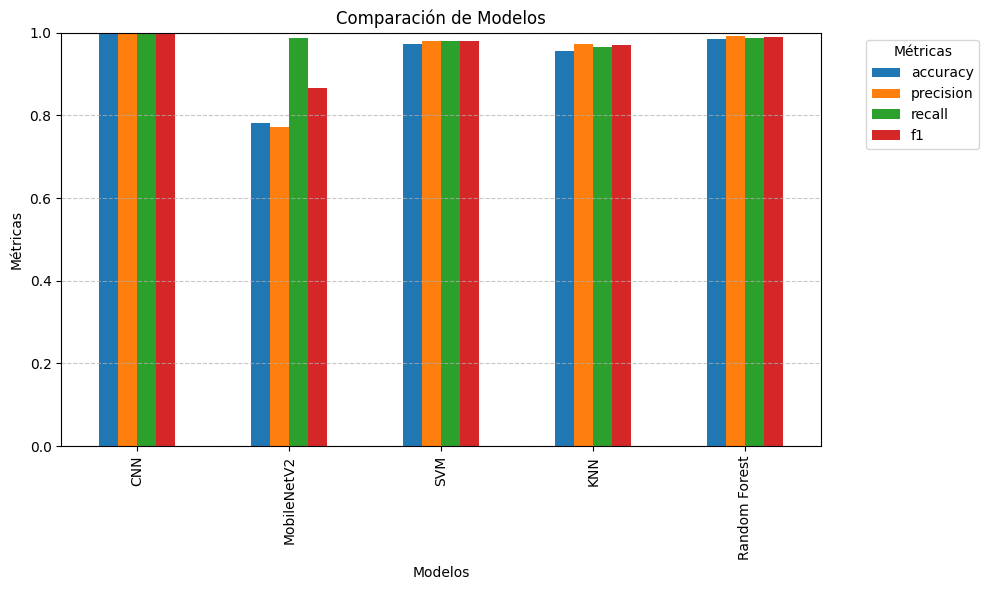

In [41]:
import matplotlib.pyplot as plt

metrics = ['accuracy', 'precision', 'recall', 'f1']

#crear gráfico de barras
results_df[metrics].plot(kind='bar', figsize=(10, 6))

plt.title('Comparación de Modelos')
plt.xlabel('Modelos')
plt.ylabel('Métricas')
plt.ylim(0, 1) 
plt.legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


En base a la tabla y a la gráfica, se puede concluir que **el modelo que tuvo el mejor resultado en general fue CNN**, con un **f1-score de 0.997**, lo que indica: 
* buen balance entre precisión y recall
* es un modelo robusto, ideal para estos casos de diagnóstico
* se adaptó mejor a las imágenes 

Además de tener excelentes resultados en todas las métricas 

#### Análisis por Matrices de Confusión

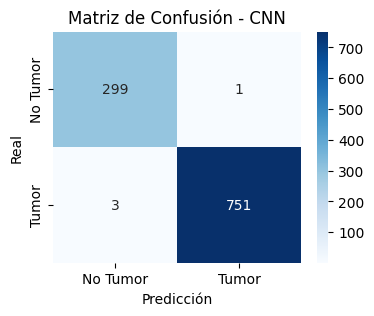

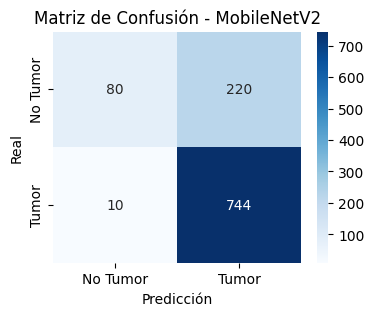

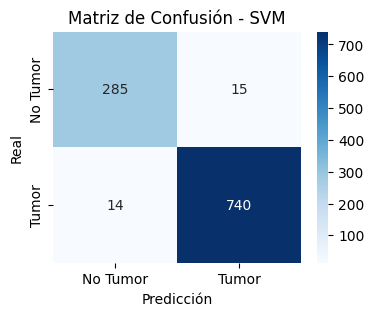

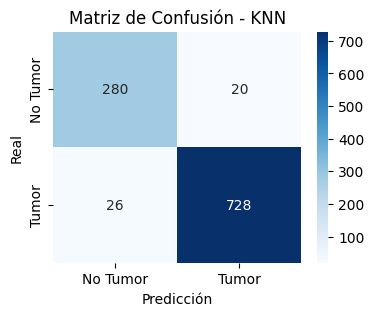

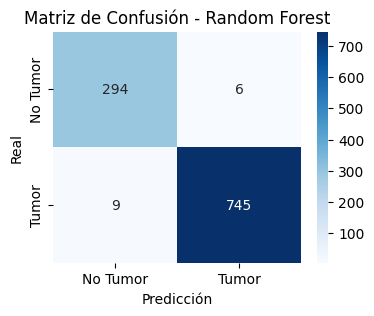

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

model_names = ['CNN', 'MobileNetV2', 'SVM', 'KNN', 'Random Forest']
preds_list = [cnn_preds, mobilenet_preds, svm_preds, kn_preds, rf_preds]

for name, preds in zip(model_names, preds_list):
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title(f'Matriz de Confusión - {name}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

**CNN:** Comenzando por el mejor modelo, que fue CNN, vemos que es el más fiable en diagnóstico. 
* En total solo tuvo 4 errores
    * 1 Falso Positivo (Clasificado como "Tumor", pero no lo es) 
    * 3 Falsos Negativos (Casos con tumor que no detectó) 
* El resto de casos fueron clasificados correctamente como "No Tumor" (299, TN) y como "Tumor" (751, TP)

**MobileNetV2:** A pesar de que tuvo un buen recall (0.987), donde detectó casi todos los tumores al igual que la CNN. Su precisión es baja (0.772). algo que observamos en el número de FP (220), es decir, los clasificó como Tumores pero NO lo son. Evidentemente en la aplicación clínica, este no es un modelo ideal. 

**Random Forest:** Entre los tres modelos clásicos, Random Forest fue el que tuvo mejores resultados, con un f1 de 0.9900, siendo similar, pero no mejor, que el de CNN sin necesidad de darle un entrenamiento profundo.
* Tuvo en total 15 errores 
    * 6 FP: clasificados como Tumor, pero no lo son
    * 9 FN: clasificados como No tumor, pero si lo son 

Podemos ver que tuvo resultados similares al de CNN, por lo que podría ser un buen modelo. Sin embargo, en la clínica lo que se busca es tener el menor número posible de errores, lo que hace que la CNN siga siendo una mejor opción, a pesar de su complejidad. 